In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from scene_synthesis.datasets.nuScenes import NuScenesDataset
from scene_synthesis.datasets.utils import collate_test
from scene_synthesis.networks.autoregressive_transformer import AutoregressiveTransformer

def to_numpy(data: dict):
    for k in data:
        if isinstance(data[k], torch.Tensor):
            data[k] = data[k].squeeze()
            if not data[k].shape:
                data[k] = data[k].item()
            else:
                data[k] = data[k].numpy()
        elif isinstance(data[k], dict):
            to_numpy(data[k])


In [2]:
np.random.seed(0)
torch.manual_seed(0)
plt.ion()
dataset = NuScenesDataset("/media/yifanlin/My Passport/data/nuScene-processed/train")
axes_limit = 40
cat2color = {1: 'red', 2: 'blue', 3: 'green'}
model = AutoregressiveTransformer()
model.load_state_dict(torch.load('./ckpts/08-12-10:25:34'))


<All keys matched successfully>

In [3]:
data = dataset[0]
input_data, length = collate_test([data], keep=0)
for k in data:
    data[k] = input_data[k].squeeze(0).numpy()


In [4]:
condition = {
    "category": None,  # int
}

/home/yifanlin/miniconda3/envs/atiss/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


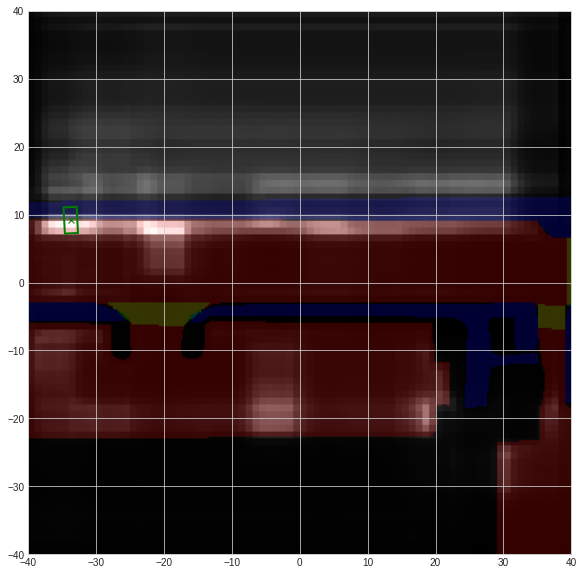

In [5]:
preds, probs, input_data, length = model.generate(input_data, length, condition, n_sample=5)
to_numpy(preds)
category = preds['category']
if category != 0:
    _, ax = plt.subplots(figsize=(10, 10))
    map_layers = np.stack(input_data['map'][0, :3], axis=-1) * 0.2
    prob_map = probs['location'].log_prob(torch.tensor(np.arange(6400))).reshape(80, 80).numpy()
    prob_map = np.exp(prob_map)
    prob_map = np.kron(prob_map, np.ones((4, 4)))
    prob_map /= prob_map.sum()
    map_layers += prob_map[..., None] / prob_map.max()
    ax.imshow(map_layers, extent=[-axes_limit, axes_limit, -axes_limit, axes_limit])
    for i in range(length.item()):
        if input_data['category'][0, i] != 0:
            color = cat2color[input_data['category'][0, i].item()]
            loc = input_data['location'][0, i].numpy()
            ax.plot(loc[0], loc[1], 'x', color=color)
            w, l, theta = input_data['bbox'][0, i].numpy()
            corners = np.array([[l / 2, w / 2],
                                [-l / 2, w / 2],
                                [-l / 2, -w / 2],
                                [l / 2, -w / 2],
                                [l / 2, w / 2]])
            rotation = np.array([[np.cos(theta), np.sin(theta)],
                                 [-np.sin(theta), np.cos(theta)]])
            corners = np.dot(corners, rotation) + loc
            ax.plot(corners[:, 0], corners[:, 1], color=color, linewidth=2)
            speed, omega = input_data['velocity'][0, i].numpy()
            rotation = np.array([[np.cos(omega), np.sin(omega)],
                                 [-np.sin(omega), np.cos(omega)]])
            velocity = np.dot(np.array([speed, 0]), rotation)
            ax.arrow(loc[0], loc[1], velocity[0] * 5, velocity[1] * 5, color=color, width=0.05)
    ax.set_xlim([-axes_limit, axes_limit])
    ax.set_ylim([-axes_limit, axes_limit])


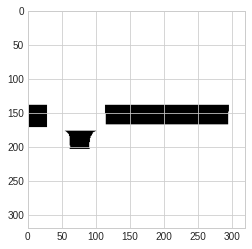

In [10]:
map = input_data['map'][0].numpy()
plt.imshow(map[3])

In [ ]:
prob_map = probs['location'].log_prob(torch.tensor(np.arange(6400))).reshape(80, 80).numpy()
prob_map = np.exp(prob_map)
plt.imshow(prob_map, extent=[-axes_limit, axes_limit, -axes_limit, axes_limit])

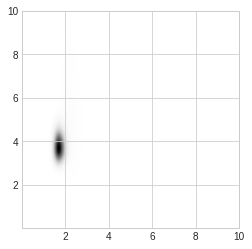

In [21]:
y, x = torch.meshgrid(torch.linspace(10, 0.01, 200), torch.linspace(0.01, 10, 200))
grids = torch.stack([x, y], dim=-1)
prob_map_wl = torch.exp(probs['wl'].log_prob(grids))
plt.imshow(prob_map_wl, extent=[0.01, 10, 0.01, 10])

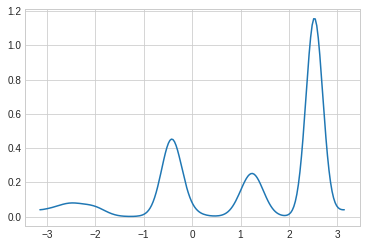

In [22]:
x = torch.linspace(-np.pi, np.pi, 200)
y = torch.exp(probs['theta'].log_prob(x[..., None]))
plt.plot(x, y)

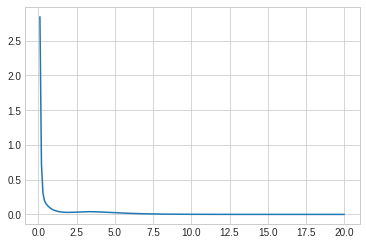

In [23]:
x = torch.linspace(0.1, 20, 200)
y = torch.exp(probs['s'].log_prob(x[..., None]))
plt.plot(x, y)

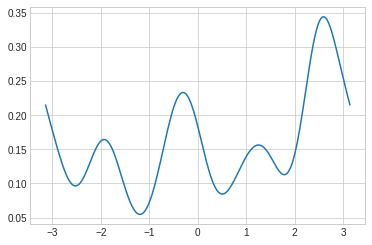

In [24]:
x = torch.linspace(-np.pi, np.pi, 200)
y = torch.exp(probs['omega'].log_prob(x[..., None]))
plt.plot(x, y)

In [3]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from datasets import NuScenesDataset, DiffusionModelPreprocessor, collate_fn
from networks import DiffusionBasedModel
import numpy as np
from matplotlib import pyplot as plt

In [2]:
device = torch.device('cpu')
np.random.seed(7)
torch.manual_seed(7)
B = 1
dataset = NuScenesDataset("/media/yifanlin/My Passport/data/nuSceneProcessed/train")
dataloader = DataLoader(dataset, batch_size=B, shuffle=True, num_workers=8, collate_fn=collate_fn)
preprocessor = DiffusionModelPreprocessor(device).test()
model = DiffusionBasedModel(time_steps=1000)
model = model.to(device)

batch = next(iter(dataloader))
batch = preprocessor(batch)

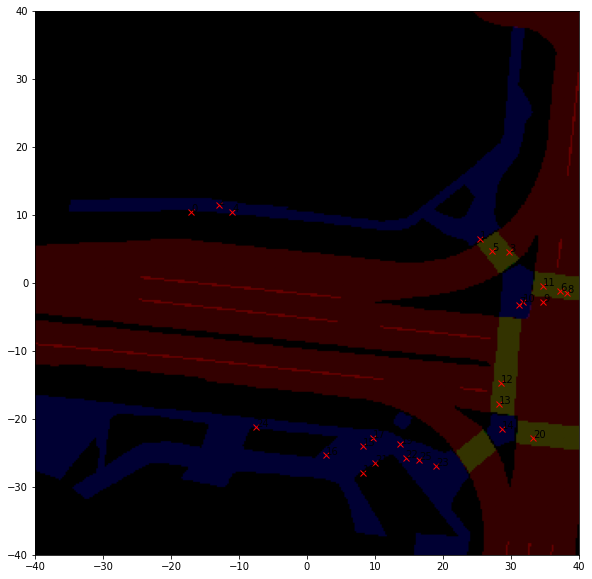

In [60]:
axes_limit = 40
t = 300

maps = batch['map']
walkable_area = (maps[:, 1] + maps[:, 2]).clamp(max=1)
pts = batch['pedestrian']['location']
pts, noise = model.perturb(pts, t, walkable_area)
pts = pts * axes_limit
length = batch['pedestrian']['length'].item()
fig, ax = plt.subplots(figsize=(10, 10))
drivable_area = batch['map'][0, 0]
ped_crossing = batch['map'][0, 1]
walkway = batch['map'][0, 2]
lane_divider = batch['map'][0, 5]
map_layers = np.stack([
    drivable_area + lane_divider,
    ped_crossing,
    walkway
], axis=-1) * 0.2
ax.imshow(map_layers, extent=[-axes_limit, axes_limit, -axes_limit, axes_limit])
for i in range(length):
    loc = pts[0, i].numpy()
    ax.plot(loc[0], loc[1], 'x', color='red')
    ax.annotate(str(i), loc)

ax.set_xlim([-axes_limit, axes_limit])
ax.set_ylim([-axes_limit, axes_limit])
plt.show()

In [61]:
noise.norm(dim=-1).mean()

tensor(0.1209)

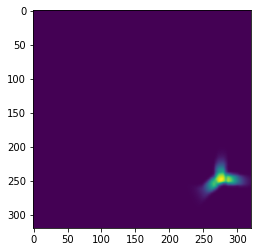

In [70]:
pts = batch['pedestrian']['location']
diffused = model.diffuse(pts, 320, model.diffuse_factors[t])
blurred = model.blur(walkable_area, model.blur_factors[t]) + 1e-3
prob = blurred.unsqueeze(1) * diffused
plt.imshow(prob[0, 20])
plt.show()

In [34]:
prob[0, 0, 300, 220]

tensor(3.3108e-06)

In [54]:
with torch.no_grad():
    fmap = model.feature_extractor['pedestrian'](batch['map'])
fmap = fmap[0].flatten(1).T
fmap.shape

torch.Size([102400, 128])

In [55]:
from sklearn.decomposition import PCA



reduced = PCA(n_components=3).fit_transform(fmap.numpy())
reduced.shape

(102400, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


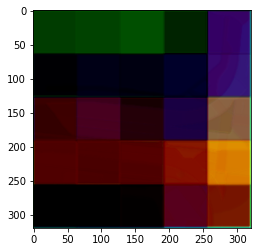

In [59]:
reduced = reduced.reshape(320, 320, 3)
reduced /= reduced.max()
plt.imshow(reduced)
plt.show()